# Workshop 3

This exercise demonstrates the power and flexibility of text generation. By the end of the exercise, you will have learned to:
- Use LLMs for zero-shot text classification
- Use one of the best open LLMs as synthetic participants in psychological experiments

## Environment Setup 

In [1]:
import sys
if 'google.colab' in sys.modules:  # If in Google Colab environment
    # Mount google drive to enable access to data files
    from google.colab import drive
    drive.mount('/content/drive')
    
    # Installing requisite packages
    !pip install --upgrade transformers openai  &> /dev/null

    # Change working directory 
    %cd /content/drive/MyDrive/LLM4BeSci_EADM2024/workshop_3

In [2]:
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm_notebook as tqdm
from huggingface_hub import InferenceClient
import textwrap

## Zero-shot Classification: Media Bias
The goal of this section will be to classify tweets as either `"neutral"` or `"partisan"`. We will make use of a [dataset](https://data.world/crowdflower/classification-of-pol-social) of tweets containing four columns:

1. `"author"`: The author of the tweet.
2. `"text"`: The text of the tweet.
3. `"bias"`:  The political bias of the tweet. This can be either `"neutral"` or `"partisan"`. The number of neutral and partisan tweets is intentionally equal in the dataset.
4. `"type"`:  The type of tweet.

We begin by loading the dataset as a `pandas.DataFrame`:

In [3]:
media_bias = pd.read_csv('media_bias.csv')
media_bias

,author,text,bias,type,audience
0,Dina Titus (Representative from Nevada),"#FMLA has been helping families for 20 years, ...",neutral,support,national
1,Tim Griffin (Representative from Arkansas),"Join me for another ""#SweetTea with Tim"" in #S...",neutral,media,national
2,Alan Grayson (Representative from Florida),The Original Chickenhawk. http://t.co/gqThSecLxB,neutral,policy,national
3,Michelle Lujan Grisham (Representative from Ne...,Like my @facebook page for updates on how I'm ...,neutral,mobilization,constituency
4,Dean Heller (Senator from Nevada),@NevadaWolfPack's own @Kaepernick7 = Best Brea...,neutral,personal,constituency
...,...,...,...,...,...
95,Andy Harris (Representative from Maryland),13k plans at risk RT @ReutersUS: Aetna exits O...,partisan,information,national
96,Doug Collins (Representative from Georgia),"Targeting conservatives by day, partying by ni...",partisan,policy,national
97,David Schweikert (Representative from Arizona),Great talk earlier tonight w/@TheKudlowReport....,partisan,policy,national
98,Joe Barton (Representative from Texas),"President calls for ""modern pipelines."" What a...",partisan,attack,national


The code next initializes the `InferenceClient` with an access token, **which you will need to replace with the HF Pro token we sent you**. It then loops through the tweets in the `media_bias` dataframe. The code then generates the output using the `chat_completion` method of the `InferenceClient` class. This allows us to play around with certain generation-related parameters such as `max_tokens` and `temperature`. 

The output is then parsed to extract the label, which is then appended to the `zero_shot_labels` list. The code then adds the `zero_shot_labels` list to the `media_bias` dataframe.

In [4]:
# Initialize client
api_key = '<pro_token_here>' 
client = InferenceClient(token=api_key)

# Zero-shot classification prompt
zero_shot_prompt = "Is this text neutral or partisan? Strictly answer with only 'neutral' or 'partisan':\n"

zero_shot_labels = []
for tweet in tqdm(media_bias['text']):    
    
    # Zero-shot classification 
    output = client.chat_completion(
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": zero_shot_prompt + tweet}
        ],
        model="meta-llama/Meta-Llama-3.1-8B-Instruct",
        max_tokens=50,
        temperature=0.0
    )
    
    # Accessing the text output and lowercasing it
    output = output.choices[0].message.content.lower()
    
    # Extract label and append to list
    label = 'neutral' if 'neutral' in output else 'partisan' if 'partisan' in output else 'nan' # 
    zero_shot_labels.append(label)

# Add zero-shot labels to dataframe
media_bias['zero_shot_label'] = zero_shot_labels
media_bias

  0%|          | 0/100 [00:00<?, ?it/s]

Server https://api-inference.huggingface.co/models/meta-llama/Meta-Llama-3.1-8B-Instruct/v1/chat/completions does not seem to support chat completion. Falling back to text generation. Error:  (Request ID: -BL5KGHXFK_wz0KskYGA3)

Bad request:
Model requires a Pro subscription; check out hf.co/pricing to learn more. Make sure to include your HF token in your query.


BadRequestError:  (Request ID: bmWDakSE0PZWLOAdX_vJw)

Bad request:
Model requires a Pro subscription; check out hf.co/pricing to learn more. Make sure to include your HF token in your query.

In [9]:
# Comparing zero-shot and actual labels
print(f'Zero-shot accuracy: {(media_bias["zero_shot_label"] == media_bias["bias"]).mean()}')

Zero-shot accuracy: 0.74


Impressively, without any task-specific training, the model achieves an accuracy of 74%. This compares to a baseline accuracy of 50% that could be achieved by randomly guessing between the two classes.

The results can also be visualized with a confusion matrix, which shows the number of true positives, true negatives, false positives, and false negatives. The confusion matrix can be used to identify where the model is making mistakes and to understand the types of errors.

<Axes: xlabel='zero_shot_label', ylabel='bias'>

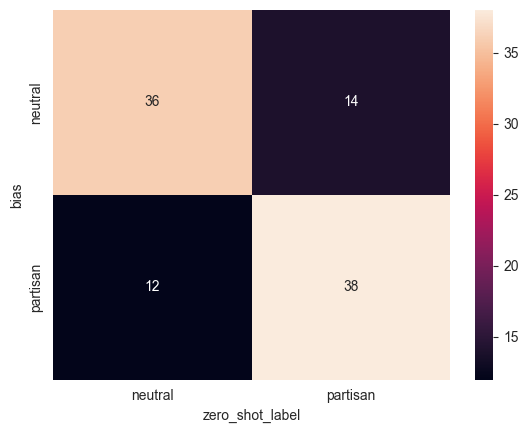

In [10]:
# Confusion matrix
confusion = pd.crosstab(media_bias['bias'], media_bias['zero_shot_label'])
sns.heatmap(confusion, annot=True)

As you can see, the model might have a slight bias towards classifying tweets as partisan, leading to a higher number of false postives than false negatives.

**TASK 1**: Try playing around with the system prompt to give it different roles. Can you find one that increases the accuracy of Llama 3? (e.g. `"You are a thoughtful political scientist who accurately distinguishes neutral and partisan messages"`).<br>

## Synthetic Participants: The Berlin Numeracy Test
In this section, we will explore the usage of causal LLMs as synthetic participants in a psychological experiment. We will this time use the 70B parameter version of Llama 3 to solve the [Berlin Numeracy Test](https://doi.org/10.1017/S1930297500001819). This is a widely used test to measure an individual's ability to understand and apply statistical concepts. 

The test consists of four questions that require a basic understanding of probability and statistics. In this exercise, we will ask Llama 3 to solve these questions. Llama 3 will provide an answer to each question, and we will evaluate the quality of the response.

The code begins by defining the four questions: 

In [5]:
q1 = """
Imagine we are throwing a five-sided die 50 times. On average, out of these 50 throws how many times would this five-sided die show an odd number (1, 3 or 5)?
"""

q2 = """
Out of 1,000 people in a small town 500 are members of a choir. Out of these 500 members in the choir 100 are men. Out of the 500 inhabitants that are not in the choir 300 are men. What is the probability that a randomly drawn man is a member of the choir? (please indicate the probability in percent).
"""

q3 = """
Imagine we are throwing a loaded die (6 sides). The probability that the die shows a 6 is twice as high as the probability of each of the other numbers. On average, out of these 70 throws, how many times would the die show the number 6?
"""

q4 = """
In a forest 20% of mushrooms are red, 50% brown and 30% white. A red mushroom is poisonous with a probability of 20%. A mushroom that is not red is poisonous with a probability of 5%. What is the probability that a poisonous mushroom in the forest is red?
"""

In [13]:
# Loop through questions and generate responses
for i, question in enumerate([q1, q2, q3, q4]):
    print('-------------------------')   
    
    # Add additional instruction to the question
    question += """
    Return your answer immediately with no working, then explain your answer.
    Add ** around your final answer to make it more visible.
     """
    
    output = client.chat_completion(
    messages=[
        {"role": "system", "content": "You are an average participant in a psychology experiment."},
        {"role": "user", "content": question}
    ],
    model="meta-llama/Meta-Llama-3.1-8B-Instruct",
    max_tokens=1000,
    temperature=0.0
    )
    
    # Accessing the text output 
    response = output.choices[0].message.content
    
    # Format question and response for printing
    question = '\n'.join(textwrap.wrap(question, 100))
    response = '\n'.join(textwrap.wrap(response, 100))
    print(f"Question {i+1}: {question} \n\nAnswer: {response}\n")

-------------------------
Question 1:  Imagine we are throwing a five-sided die 50 times. On average, out of these 50 throws how many
times would this five-sided die show an odd number (1, 3 or 5)?      Return your answer immediately
with no working, then explain your answer.     Add ** around your your final answer to make it more
visible. 

Answer: **25**  This is because a five-sided die has an equal probability of landing on each of its five
sides. Since three of the sides (1, 3, and 5) are odd numbers, and two sides (2 and 4) are even
numbers, the probability of landing on an odd number is 3/5.   To find the expected number of times
an odd number appears in 50 throws, we can multiply the probability of getting an odd number (3/5)
by the total number of throws (50). This gives us (3/5) * 50 = 30. However, since the die is fair
and the probability of getting an odd number is 3/5, we can also think of it as 3 out of every 5
throws being odd. Therefore, in 50 throws, we would expect 3

The correct answers are 30, 25, 20, and 50, meaning the model only got 1/4 questions correct. 

**TASK 1**: Change the `temperature` value to `1.0`, `3.0`, and `float('inf')`. What impact does temperature have on the responses?<br>
**TASK 2**: Change the `temperature` back to `0.0`. Now remove the instruction to `"Return your answer immediately with no working, then explain your answer."` and replace it with a *chain-of-thought* prompt instructing the model to `"Go through your reasoning step by step before giving the final answer."`. Why do you think this might improve the quality of the responses?<br>
**TASK 3**: Try changing the `model` to `"meta-llama/Meta-Llama-3.1-70B-Instruct"`. Does the larger model do any better?<br>